In [55]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  8 18:46:22 2019


Load MNIST dataset and implement an autoencoder with only a few layers to do manifold learning

@author: rvulling
"""

import struct as st
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import clear_output
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, AvgPool2D, UpSampling2D, ReLU, MaxPooling2D, \
    Reshape, Softmax, Activation, Flatten, Lambda, Conv2DTranspose
from tensorflow.keras.losses import MSE, categorical_crossentropy, binary_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import sklearn
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.datasets import mnist

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

args = {
    'epochs': 10,
    'batch_size': 64
}


def build_batches(x, n):
    m = (x.shape[0] // n) * n
    return x[:m].reshape(-1, n, *x.shape[1:])


def get_mnist32_batches(batch_size, data_format='channels_last'):
    maxNum_data_train = 10000  # reduce data size for computational load
    maxNum_data_test = 1000
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    data_x_train = X_train.reshape(-1, 28, 28).astype(np.float32) / 255.
    data_x_test = X_test.reshape(-1, 28, 28).astype(np.float32) / 255.

    # Reduce dimensions of dataset to reduce computations times
    np.random.seed(42)  # seed to ensure reproducible results
    randomIndices_train = np.random.permutation(np.size(data_x_train, 0))
    randomIndices_test = np.random.permutation(np.size(data_x_test, 0))
    indicesTrain = randomIndices_train[0:maxNum_data_train]
    indicesTest = randomIndices_test[0:maxNum_data_test]
    data_x_train = data_x_train[indicesTrain, :, :]  # Reduce dimensions of dataset to reduce computations times
    data_x_train = np.pad(data_x_train, ((0, 0), (2, 2), (2, 2)), mode='constant')
    data_x_train = np.expand_dims(data_x_train, -1)
    data_x_test = data_x_test[indicesTest, :, :]
    data_x_test = np.pad(data_x_test, ((0, 0), (2, 2), (2, 2)), mode='constant')
    data_x_test = np.expand_dims(data_x_test, -1)
    data_y_train = Y_train[indicesTrain]  # Reduce dimensions of dataset to reduce computations times
    data_y_test = Y_test[indicesTest]  # Reduce dimensions of dataset to reduce computations times
    indices = np.arange(len(data_x_train))
    # np.random.shuffle(indices)
    y_batches = build_batches(data_y_train[indices], batch_size)
    x_batches = build_batches(data_x_train[indices], batch_size)
    return x_batches, y_batches, data_x_train, data_y_train, data_x_test, data_y_test


x_batches, y_batches, data_x_train, data_y_train, data_x_test, data_y_test = get_mnist32_batches(args['batch_size'])


def Encoder(input_shape):
    print(input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_shape)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    encode = MaxPooling2D((2, 1))(x)
    print(encode.shape)
    return encode

def Decoder(input_shape):
    print(input_shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(input_shape)
    print(x.shape)
    x = UpSampling2D((2, 1))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = UpSampling2D((2, 2))(x)
    print(x.shape)
    decode = Conv2DTranspose(1, (3, 3), activation='relu', padding='same')(x)
    print(decode.shape)
    return decode

"""
Create models    
"""
input_shape = x_batches.shape[2:]


inputs = Input(input_shape)
encoded = Encoder(inputs)
decoded = Decoder(encoded)
model = tf.keras.Model(inputs=inputs, outputs=decoded)

model.compile('adam', loss= MSE)
#model.compile('adam', loss=lambda yt, yp: MSE(inputs, decoded))

"""
Train model or load weights of previously trained model
"""

history = model.fit(data_x_train, data_x_train,
              epochs=10,
              batch_size=64,
              shuffle=True,
              validation_data=(data_x_test, data_x_test))


Tensor("input_7:0", shape=(None, 32, 32, 1), dtype=float32)
(None, 32, 32, 16)
(None, 16, 16, 16)
(None, 16, 16, 16)
(None, 8, 8, 16)
(None, 8, 8, 16)
(None, 4, 4, 16)
(None, 4, 4, 16)
(None, 2, 2, 16)
(None, 2, 2, 1)
(None, 1, 2, 1)
Tensor("max_pooling2d_30/MaxPool:0", shape=(None, 1, 2, 1), dtype=float32)
(None, 1, 2, 16)
(None, 2, 2, 16)
(None, 2, 2, 16)
(None, 4, 4, 16)
(None, 4, 4, 16)
(None, 8, 8, 16)
(None, 8, 8, 16)
(None, 16, 16, 16)
(None, 16, 16, 16)
(None, 32, 32, 16)
(None, 32, 32, 1)
Train on 10000 samples, validate on 1000 samples
Epoch 1/10
 2368/10000 [======>.......................] - ETA: 9s - loss: 0.0613

KeyboardInterrupt: 

In [7]:
# Encode and decode some digits
# Note that we take them from the *test* set


decoded_imgs = model.predict(x_batches[0,0:10])

(10, 32, 32, 1)

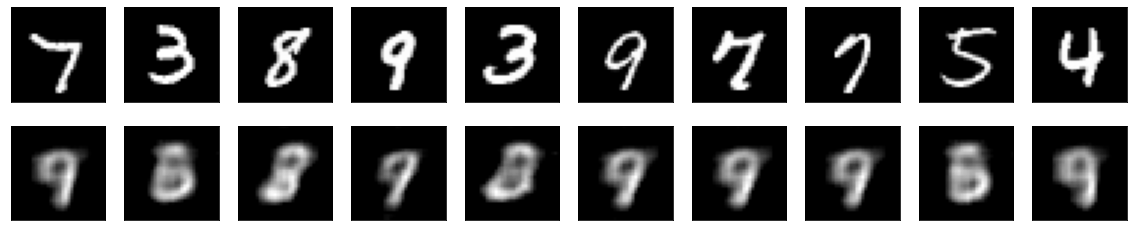

In [8]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_batches[0,i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig("autoencoder_reconstruction.png")
plt.show()

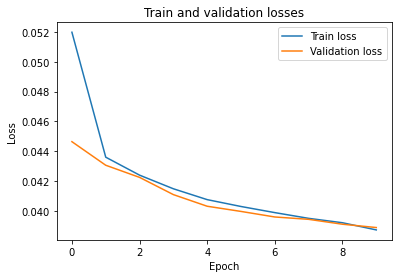

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and validation losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.savefig('Train_and_val_losses.png')
plt.show()

In [72]:
def Encoder(input_shape):
    print(input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_shape)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Flatten()(x)
    encode = Dense(10, activation='sigmoid')(x)
    print(encode.shape)
    return encode


input_shape = x_batches.shape[2:]


inputs = Input(input_shape)
encoded = Encoder(inputs)

model = tf.keras.Model(inputs=inputs, outputs=encoded)

model.compile('adam', loss="categorical_crossentropy")
#model.compile('adam', loss=lambda yt, yp: MSE(inputs, decoded))

"""
Train model or load weights of previously trained model
"""

history = model.fit(data_x_train, new_y_train,
              epochs=10,
              batch_size=64,
              shuffle=True,
              validation_data=(data_x_test, new_y_test))

    
    

Tensor("input_8:0", shape=(None, 32, 32, 1), dtype=float32)
(None, 32, 32, 16)
(None, 16, 16, 16)
(None, 16, 16, 16)
(None, 8, 8, 16)
(None, 8, 8, 16)
(None, 4, 4, 16)
(None, 4, 4, 16)
(None, 2, 2, 16)
(None, 10)
Train on 10000 samples, validate on 1000 samples
Epoch 1/10
 5056/10000 [==============>...............] - ETA: 2s - loss: 1.8198- ETA

KeyboardInterrupt: 

In [28]:
new_y_train = np.zeros((10000, 10))
new_y_test = np.zeros((1000, 10))

for i in range(10000):
    train_number = data_y_train[i]
    new_y_train[i,train_number] = 1
    
for i in range(1000):
    train_number = data_y_train[i]
    new_y_train[i,train_number] = 1
    


In [56]:
encoded_imgs = model.predict(data_x_test)
encoded_img_train = model.predict(data_x_train)

c:\users\20174215\documents\vakken\master jaar 1\q4\5lsl0\autoencoder\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


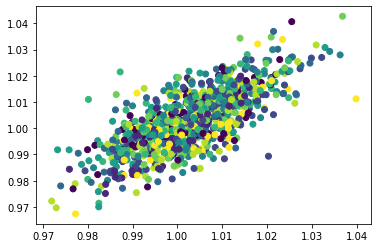

In [81]:
x=encoded_imgs[:,0,0,0]
y=encoded_imgs[:,0,1,0]
plt.scatter(x,y,c=data_y_test)

x_train=encoded_img_train[:,0,0,0]
y_train=encoded_img_train[:,0,1,0]


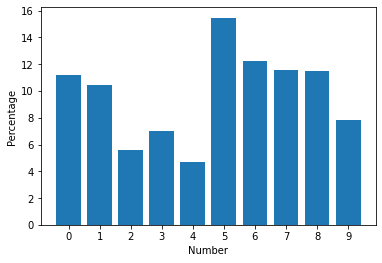

In [49]:
neigh = NearestNeighbors(n_neighbors=1)
X_train = np.array([[x_train, y_train]])[0].T
X_test = np.array([[x, y]])[0].T
neigh.fit(X_train)
distances, indices = neigh.kneighbors(X_test)

correct = np.zeros((10, 1))
total = np.zeros((10, 1))

for i in range(1000):
    real_number = data_y_test[i]
    neigh_number = data_y_train[indices][i][0]
    total[real_number] = total[real_number] + 1
    if real_number == neigh_number:
        correct[real_number] = correct[real_number] + 1
        
percentages = correct[:,0]/total[:,0]*100
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.bar(numbers,percentages)
plt.ylabel('Percentage')
plt.xlabel('Number')
plt.savefig('Barchart_neigh_per.png')
plt.show()

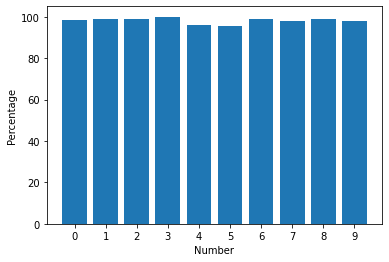

In [54]:
correct = np.zeros((10, 1))
total = np.zeros((10, 1))

for i in range(1000):
    real_number = data_y_test[i]
    fitted_number = np.argmax(encoded_imgs[i])
    total[real_number] = total[real_number] + 1
    if real_number == fitted_number:
        correct[real_number] = correct[real_number] + 1

percentages = correct[:,0]/total[:,0]*100
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.bar(numbers,percentages)
plt.ylabel('Percentage')
plt.xlabel('Number')
plt.savefig('Barchart_encoder_per.png')
plt.show()

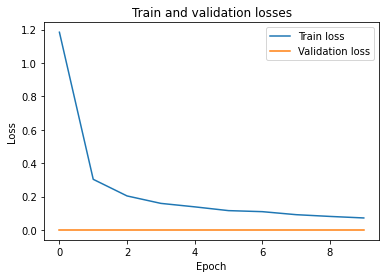

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and validation losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.savefig('Train_and_val_losses_encoder.png')
plt.show()

Tensor("input_10:0", shape=(None, 32, 32, 1), dtype=float32)
(None, 32, 32, 16)
(None, 16, 16, 16)
(None, 16, 16, 16)
(None, 8, 8, 16)
(None, 8, 8, 16)
(None, 4, 4, 16)
(None, 4, 4, 16)
(None, 2, 2, 16)
(None, 2, 2, 1)
(None, 1, 2, 1)
Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 7s 709us/sample - loss: 0.1069
Epoch 2/10
10000/10000 [==============================] - 4s 425us/sample - loss: 9.8059e-04
Epoch 3/10
10000/10000 [==============================] - 4s 444us/sample - loss: 5.1605e-04
Epoch 4/10
10000/10000 [==============================] - 4s 411us/sample - loss: 3.5618e-04
Epoch 5/10
10000/10000 [==============================] - 4s 407us/sample - loss: 2.9820e-04
Epoch 6/10
10000/10000 [==============================] - 4s 395us/sample - loss: 2.2822e-04
Epoch 7/10
10000/10000 [==============================] - 4s 398us/sample - loss: 1.9939e-04
Epoch 8/10
10000/10000 [==============================] - 5s 500us/sample - loss: 1.7798e-04
Ep

c:\users\20174215\documents\vakken\master jaar 1\q4\5lsl0\autoencoder\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


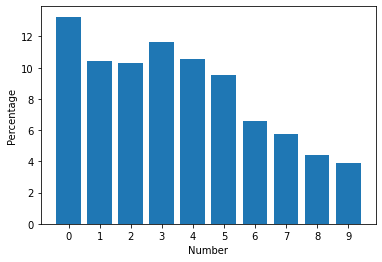

In [76]:
def Encoder(input_shape):
    print(input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_shape)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
    print(x.shape)
    encode = MaxPooling2D((2, 1))(x)
    print(encode.shape)
    return encode

input_shape = x_batches.shape[2:]
inputs = Input(input_shape)
encoded = Encoder(inputs)


model = tf.keras.Model(inputs=inputs, outputs=encoded)

model.compile('adam', loss= MSE)

history = model.fit(data_x_train,
              epochs=10,
              batch_size=64,
              shuffle=True)

encoded_imgs = model.predict(data_x_test)
encoded_img_train = model.predict(data_x_train)

x=encoded_imgs[:,0,0,0]
y=encoded_imgs[:,0,1,0]

x_train=encoded_img_train[:,0,0,0]
y_train=encoded_img_train[:,0,1,0]

neigh = NearestNeighbors(n_neighbors=1)
X_train = np.array([[x_train, y_train]])[0].T
X_test = np.array([[x, y]])[0].T
neigh.fit(X_train)
distances, indices = neigh.kneighbors(X_test)

correct = np.zeros((10, 1))
total = np.zeros((10, 1))

for i in range(1000):
    real_number = data_y_test[i]
    neigh_number = data_y_train[indices][i][0]
    total[real_number] = total[real_number] + 1
    if real_number == neigh_number:
        correct[real_number-1] = correct[real_number] + 1
        
percentages = correct[:,0]/total[:,0]*100
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.bar(numbers,percentages)
plt.ylabel('Percentage')
plt.xlabel('Number')
plt.savefig('Barchart_neigh_per.png')
plt.show()

array([13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.])

In [70]:
data_y_train[indices]

array([[9],
       [3],
       [1],
       [6],
       [6],
       [8],
       [6],
       [1],
       [4],
       [9],
       [5],
       [0],
       [6],
       [9],
       [5],
       [1],
       [4],
       [1],
       [8],
       [1],
       [1],
       [1],
       [6],
       [8],
       [5],
       [6],
       [1],
       [1],
       [3],
       [5],
       [9],
       [7],
       [8],
       [0],
       [8],
       [1],
       [8],
       [6],
       [4],
       [0],
       [7],
       [3],
       [4],
       [9],
       [8],
       [0],
       [1],
       [9],
       [8],
       [0],
       [0],
       [8],
       [3],
       [9],
       [2],
       [1],
       [3],
       [9],
       [9],
       [1],
       [4],
       [0],
       [7],
       [1],
       [7],
       [6],
       [1],
       [6],
       [2],
       [1],
       [1],
       [8],
       [4],
       [6],
       [5],
       [7],
       [0],
       [9],
       [3],
       [8],
       [5],
       [9],
       [1],
    

In [71]:
data_y_test

array([6, 9, 8, 5, 9, 9, 7, 9, 3, 2, 2, 7, 1, 5, 6, 9, 8, 2, 7, 4, 2, 7,
       9, 9, 5, 4, 7, 1, 5, 5, 8, 9, 0, 5, 2, 6, 7, 9, 5, 8, 0, 5, 1, 9,
       8, 4, 5, 1, 8, 3, 4, 1, 0, 4, 3, 9, 8, 0, 4, 3, 0, 7, 3, 8, 5, 2,
       1, 7, 1, 0, 3, 4, 7, 6, 8, 7, 9, 4, 9, 2, 5, 0, 4, 4, 1, 1, 7, 1,
       0, 0, 6, 1, 5, 1, 7, 0, 7, 6, 9, 2, 6, 8, 3, 2, 4, 0, 8, 9, 1, 2,
       6, 0, 7, 9, 4, 2, 0, 2, 8, 4, 1, 9, 6, 5, 2, 0, 3, 8, 0, 9, 8, 7,
       9, 0, 4, 4, 1, 0, 3, 5, 2, 0, 1, 8, 1, 0, 8, 5, 1, 2, 8, 1, 3, 2,
       4, 5, 6, 1, 8, 6, 9, 3, 1, 3, 6, 7, 0, 2, 0, 1, 9, 1, 4, 5, 3, 7,
       7, 1, 6, 1, 6, 4, 7, 1, 7, 2, 0, 9, 9, 4, 3, 8, 2, 6, 5, 7, 8, 1,
       1, 7, 3, 0, 7, 6, 7, 4, 7, 5, 3, 5, 8, 7, 7, 3, 7, 2, 9, 6, 9, 7,
       4, 1, 4, 9, 1, 3, 8, 7, 1, 2, 6, 8, 0, 0, 8, 0, 1, 3, 2, 4, 7, 7,
       4, 2, 2, 1, 3, 4, 9, 9, 8, 0, 8, 7, 8, 8, 2, 3, 2, 7, 8, 6, 8, 8,
       9, 2, 8, 8, 1, 6, 7, 2, 0, 4, 5, 9, 7, 2, 2, 3, 8, 6, 3, 0, 4, 8,
       1, 7, 4, 8, 4, 3, 3, 0, 1, 7, 0, 2, 5, 8, 2,

array([0.98511934, 1.0032377 , 0.99484026, 1.0062975 , 0.98950833,
       0.99304813, 1.0116941 , 1.0013059 , 0.99322754, 0.9911798 ,
       0.99557155, 1.0050133 , 1.0026653 , 0.9940009 , 1.0079318 ,
       0.99698466, 0.9920693 , 0.99247766, 0.98271894, 1.0059721 ,
       0.98949784, 0.98020375, 0.9955559 , 0.99409634, 1.0016043 ,
       1.002459  , 0.98370343, 0.98719364, 0.9942817 , 0.9810714 ,
       1.0036519 , 1.0008337 , 0.99128234, 1.0002031 , 1.0056242 ,
       1.0000254 , 0.99029416, 0.9829286 , 0.98415047, 0.99522144,
       1.0032655 , 0.9913343 , 0.9888868 , 1.0159426 , 0.98902893,
       0.99993527, 1.0028404 , 0.9982246 , 1.0028595 , 0.9978357 ,
       1.0082868 , 0.98783416, 0.9929583 , 0.9894884 , 0.98840195,
       0.99219435, 0.9828792 , 1.001901  , 0.9918942 , 1.0064305 ,
       0.979678  , 0.99481165, 0.9876759 , 0.9936859 , 0.9845347 ,
       0.9777081 , 1.0135528 , 1.0071939 , 0.980484  , 1.0052463 ,
       1.0035552 , 1.0059276 , 0.9981871 , 0.99090207, 0.99169